<!-- <p style="font-size:22px;font-weight:bold"> Table of Contents</p> -->
 

# Table of Contents

1. [Introduction](#introduction)

    1.1. [Data Description](#data_description)
    
    1.2. [Data Source](#data_source)




# Introduction <a name="introduction"></a>

## Data description <a name="data_description"></a>

Wind Turbine Energy Generation Data

The data set consists of real-time SCADA data. Each data value belongs only to the relevant time period and the input variables transmitted in the data set for the time period to be predicted are prepared to be used to predict the power generation result in the same time period.


In The Power Table:
In the shared dataset, the real-time power generation amount (Power(kW)) of a wind turbine between 01.01.2019 and 14.08.2021 is given on a 10-minute basis.

In The Features Table
In addition to real-time power generation; Some SCADA data of the wind turbine were shared for the date range 01.01.2019 – 14.12.2021.

### Data source <a name="data_source"></a>

Batucan Senkal,(2022, October). Wind Turbine Power (kW) Generation Data, Version 9. Retrieved October 8, 2023 from https://www.kaggle.com/datasets/psycon/wind-turbine-energy-kw-generation-data/.



In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from prophet import Prophet

import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

# Load Data

In [13]:
# loading the power data and converting the timestamp as index
df_power=pd.read_csv('/kaggle/input/wind-turbine-energy-kw-generation-data/power.csv')
df_power['Timestamp']=pd.to_datetime(df_power['Timestamp'])
df_power.set_index('Timestamp',inplace=True)
print(df_power.head(3))

# loading the feature data and split it in to two parts train and test based on the timestamp
df_feature=pd.read_csv('/kaggle/input/wind-turbine-energy-kw-generation-data/features.csv')
df_feature['Timestamp']=pd.to_datetime(df_feature['Timestamp'])
df_feature.set_index('Timestamp',inplace=True)
df_feature.head(3)




                      Power(kW)
Timestamp                      
2019-01-01 00:00:00  705.876648
2019-01-01 00:10:00  884.711670
2019-01-01 00:20:00  982.875000


,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Operating State,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Line Frequency,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Blade-2 Actual Value_Angle-B,Blade-1 Actual Value_Angle-B,Blade-3 Actual Value_Angle-B,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Pitch Offset-1 Asymmetric Load Controller,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,Proxy Sensor_Degree-135,State and Fault,Proxy Sensor_Degree-225,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,57.000000,59.000000,52.000000,56.158333,47.053776,57.000000,18.890772,35.000000,48.576668,56.158333,55.000000,55.000000,35.873798,-205.350006,57.0,-212.126663,28.000000,52.618332,264.949768,265.629913,1735.0,16.0,-0.953030,25.0,20.110001,395.029999,17.715000,392.086670,20.0,20.0,392.413330,10.773334,682.044983,11.0,12.0,11.0,72.210175,181.896973,15.140000,0.0,0.0,50.018833,2780.0,395.0,0.0,-0.072567,0.076724,3300.0,0.0,0.0,0.0,24.0,-1.582408,3.976667,-0.761741,0.0,3138.0,0.0,-2.923333,-3.011667,5.909392,2.0,5.957316,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.0,0.058617,-0.325738,37.867054,39.281124,5.732657,1.0,5.779913
2019-01-01 00:10:00,57.693333,59.485001,52.450001,57.000000,64.969742,57.413334,28.560265,35.233334,48.000000,57.000000,55.174999,55.174999,41.370548,-176.223328,57.0,-183.403336,28.000000,53.060001,3.340425,3.055089,1735.0,16.0,-0.971856,25.0,20.424999,396.133331,17.459999,392.931671,20.0,20.0,393.040009,4.976666,683.515015,11.0,12.0,11.0,72.220482,178.224670,14.948334,0.0,0.0,50.006634,2780.0,395.0,0.0,2.632190,0.323242,3300.0,0.0,0.0,0.0,24.0,-2.231261,4.000000,-0.777843,0.0,3138.0,0.0,-3.033333,-2.975000,5.892997,2.0,5.868237,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.0,0.058617,-0.325738,-90.169106,-89.018669,5.813177,1.0,5.796757
2019-01-01 00:20:00,59.000000,60.756668,53.536667,57.775002,51.149670,58.728333,34.228813,36.000000,48.053333,57.775002,56.000000,56.000000,44.466202,-105.058334,57.0,-112.143333,28.763334,54.000000,75.649010,75.435135,1735.0,16.0,-0.988937,25.0,21.000000,397.138336,18.000000,394.028320,20.0,20.0,393.941681,0.636667,685.244995,11.0,12.0,11.0,72.364883,184.183014,14.171667,0.0,0.0,49.989101,2780.0,395.0,0.0,2.117626,-0.032209,3300.0,0.0,0.0,0.0,24.0,-2.469615,4.000000,-0.789898,0.0,3138.0,0.0,1.053333,1.028333,5.898009,2.0,5.874691,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.0,0.058617,-0.325738,-88.556343,-88.422020,5.786413,1.0,5.772958


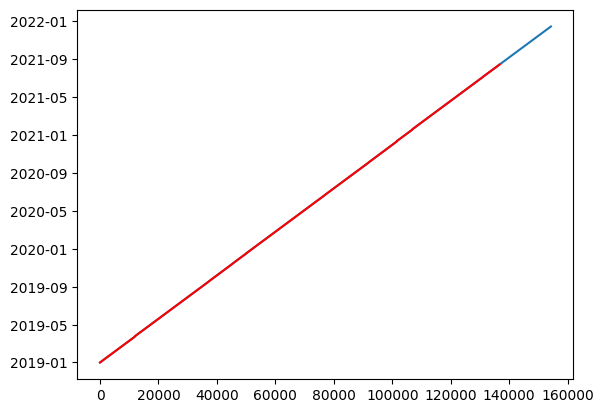

In [5]:
# the plot shows that feature data has more data, it can be used as a test data to to predict the power 

plt.plot(df_feature.index)
plt.plot(df_power.index,'r')


# Exploratory Data Analysis

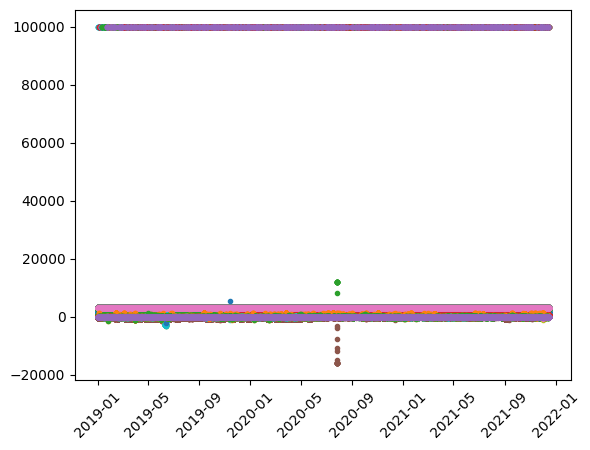

In [4]:
# the time series plot of features

for i in range(75):
    
    plt.plot(df_feature.index,df_feature.iloc[:,i].values,'.')


plt.xticks(rotation=45);


#### The above plot shows that the two bands of values for features. Here i separate the upperbnd se how the data is distributed



In [14]:
# removing values greater than 50000 or the upper band
df_feature_lower=df_feature.applymap(lambda row: row if -3500<=row<= 4000 else np.nan )
df_feature_lower = df_feature_lower.apply(lambda col: col.fillna(col.median()))

df_feature_upper=df_feature.applymap(lambda row: row if row>10000 else np.nan )

(-4000.0, 4000.0)

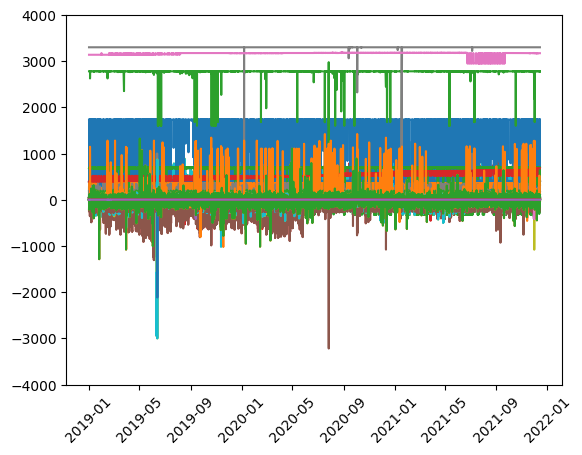

In [19]:


for i in range(75):
    
    plt.plot(df_feature_lower.index,df_feature_lower.iloc[:,i].values,'-')


plt.xticks(rotation=45);
plt.ylim([-4000,4000])

In [32]:
# A function to plot subplots of large number
def fig_fun(df,ind_strt,ind_end):
    fig,axs=plt.subplots(5,5,figsize=(15,15))
    axs=axs.reshape(-1)
    c=0
    for i in range(ind_strt,ind_end):
#         sns.boxplot(df.iloc[:,i],ax=axs[c])
        axs[c].plot(df.index,df.iloc[:,i].values)
        axs[c].set_title(f'{i}, {df.iloc[:,i].name}')

        c+=1

    plt.tight_layout()

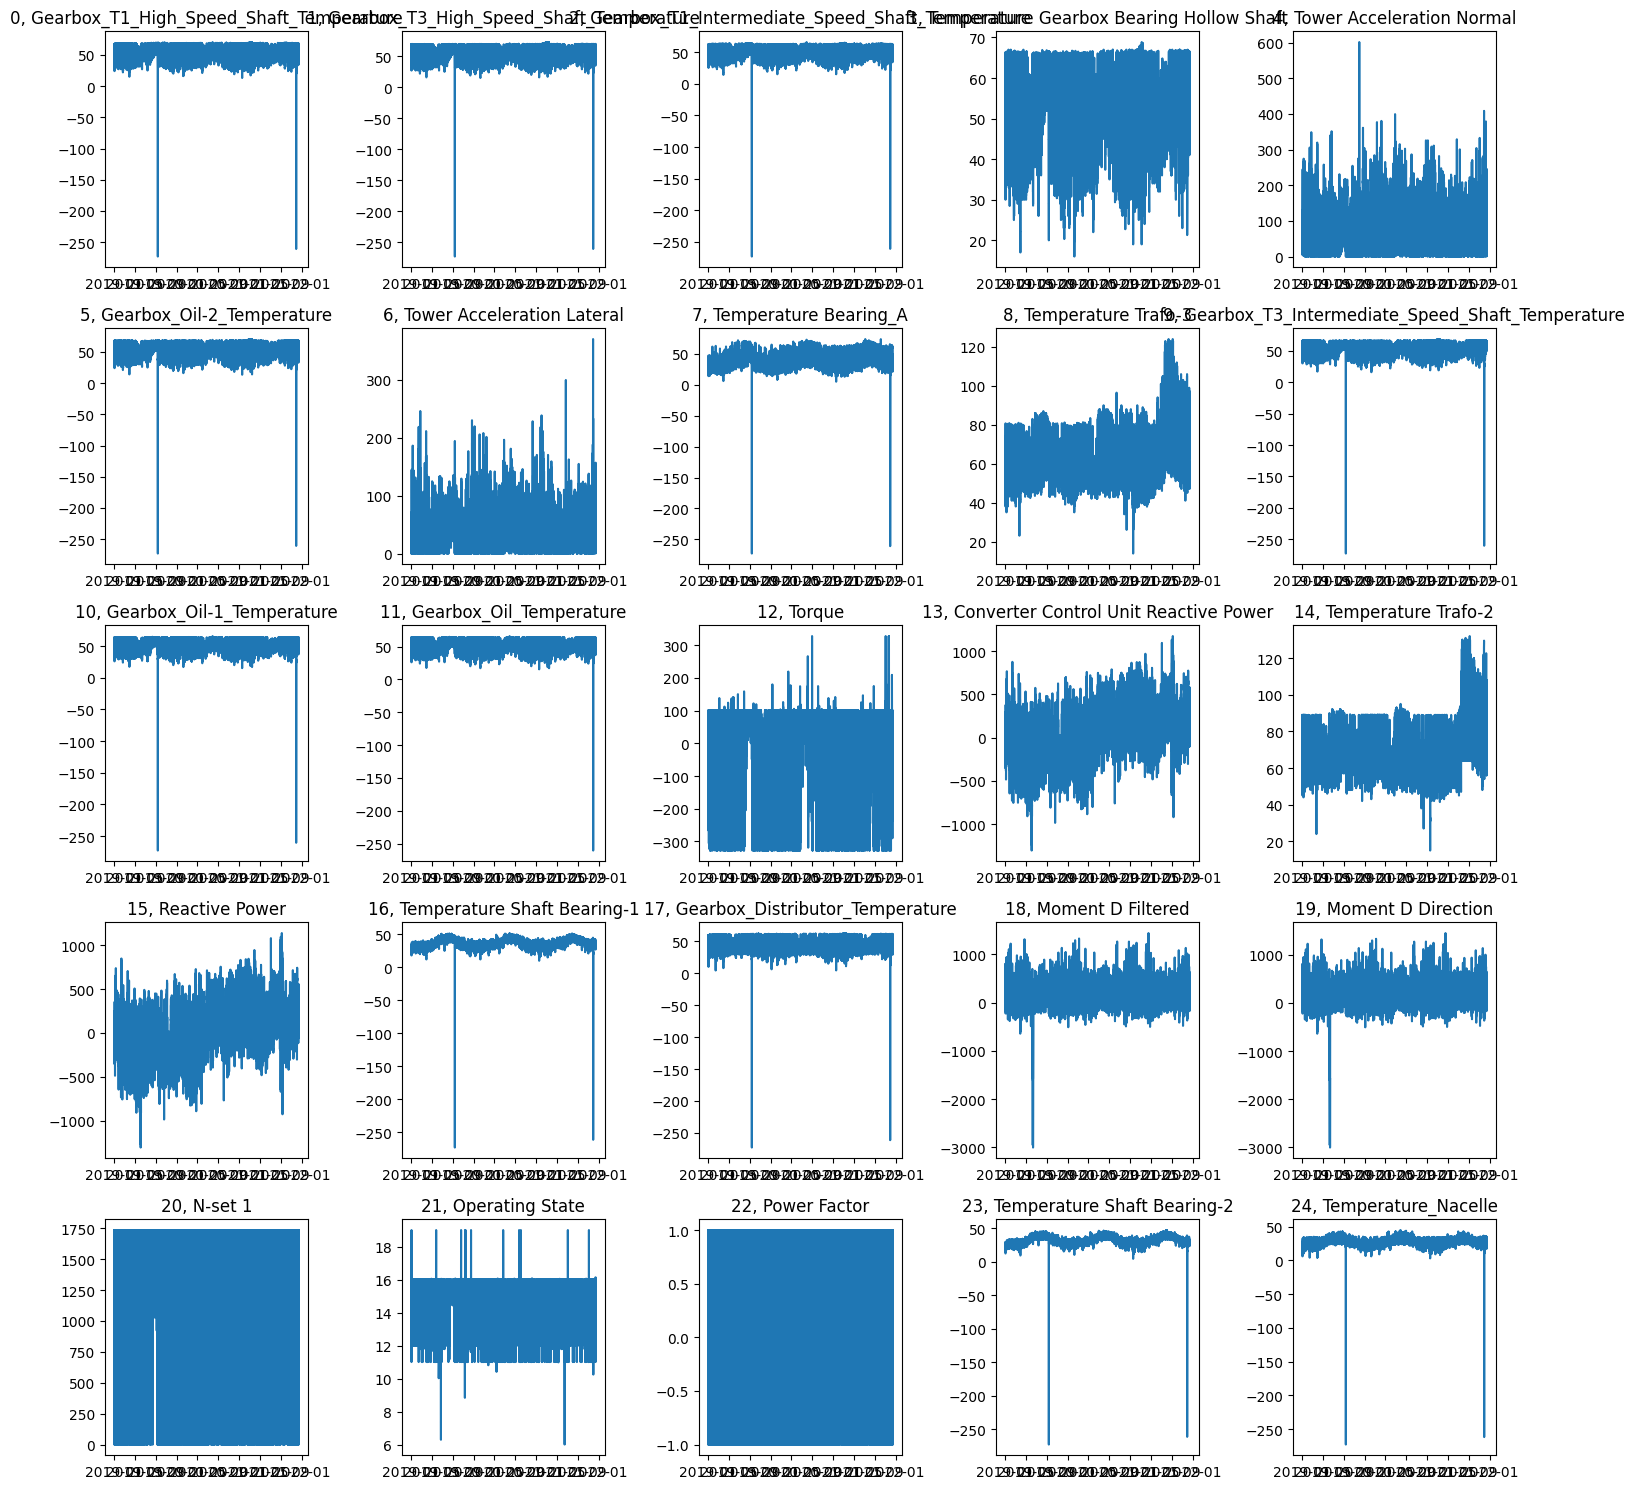

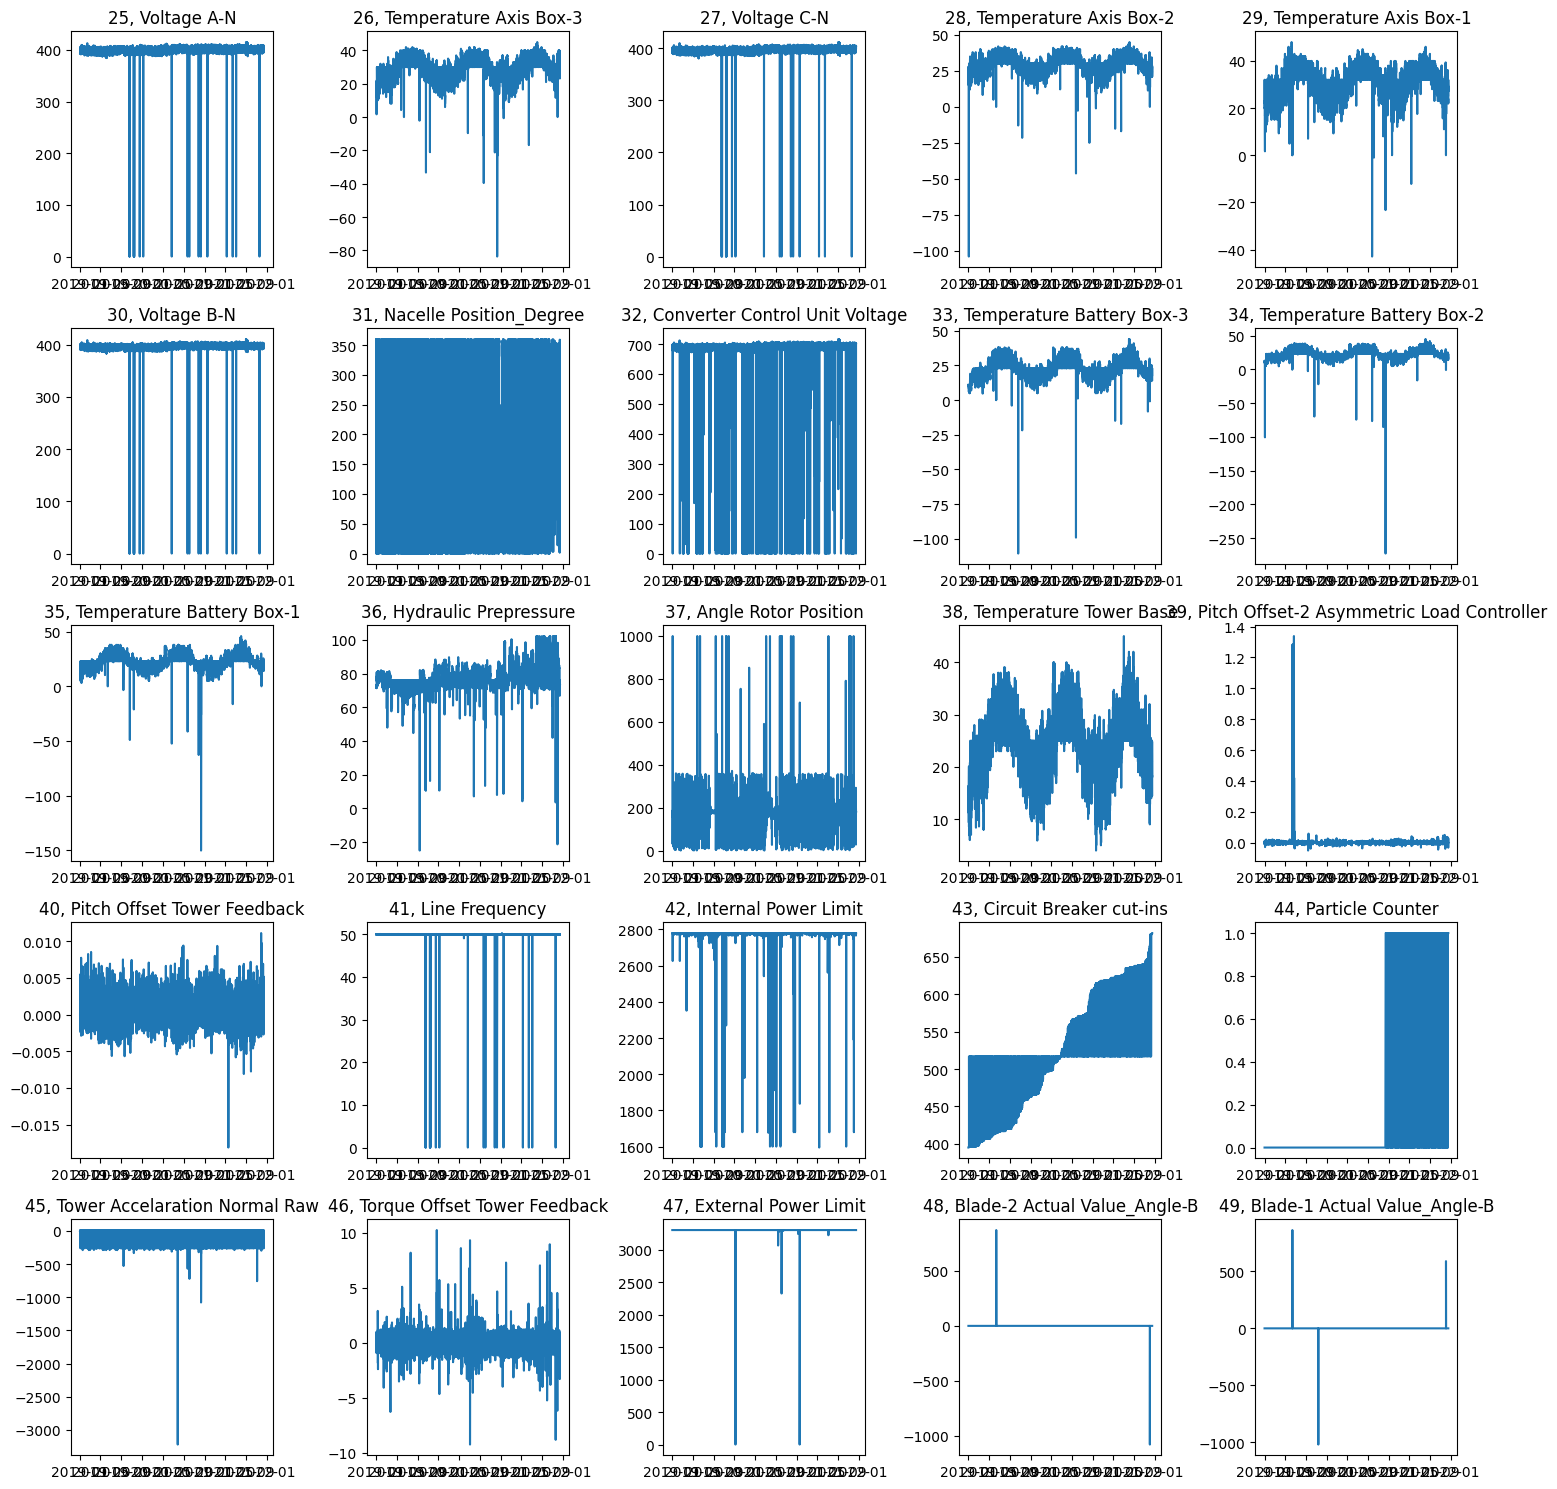

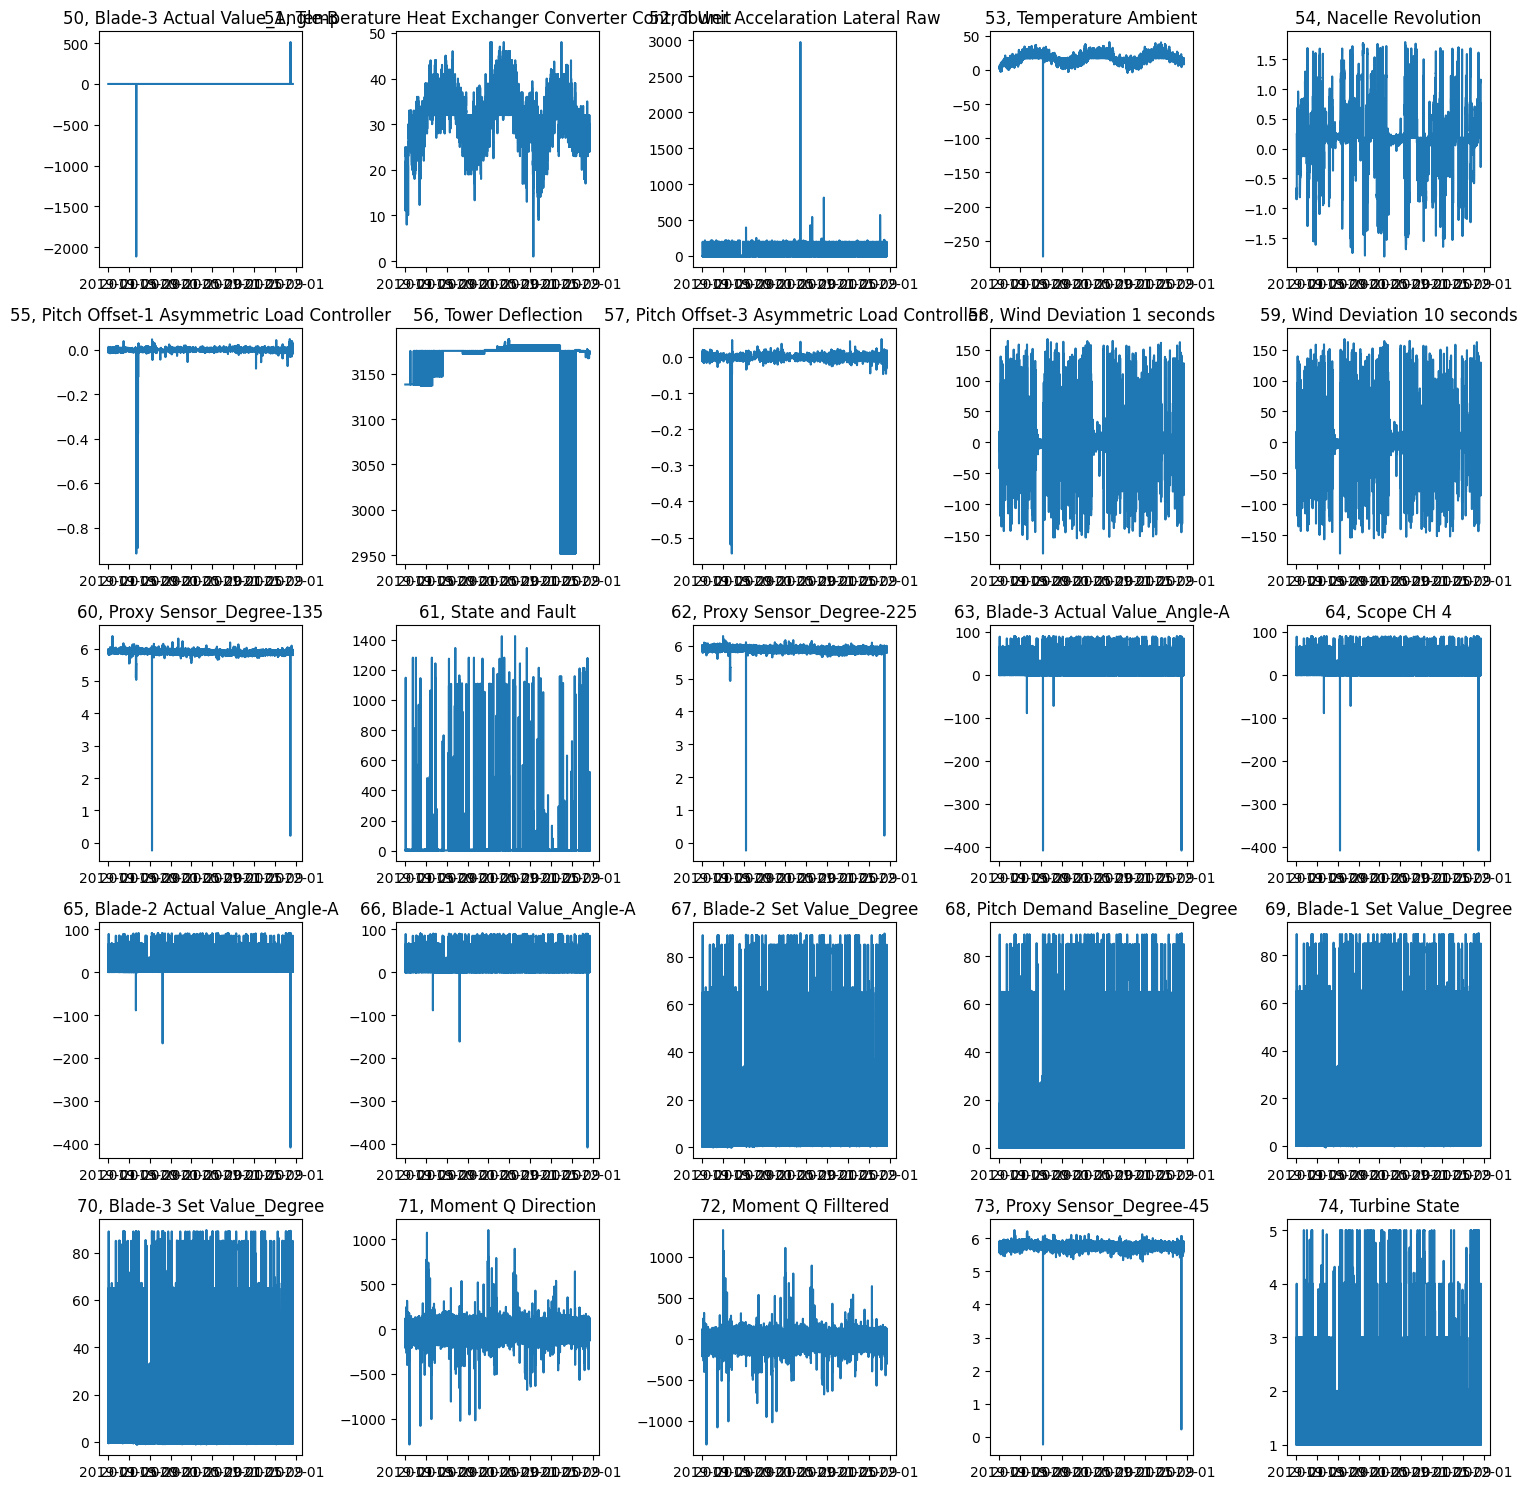

In [33]:
# time series plot
fig_fun(df_feature_lower,0,25)
plt.show()
fig_fun(df_feature_lower,25,50)
plt.show()
fig_fun(df_feature_lower,50,75)

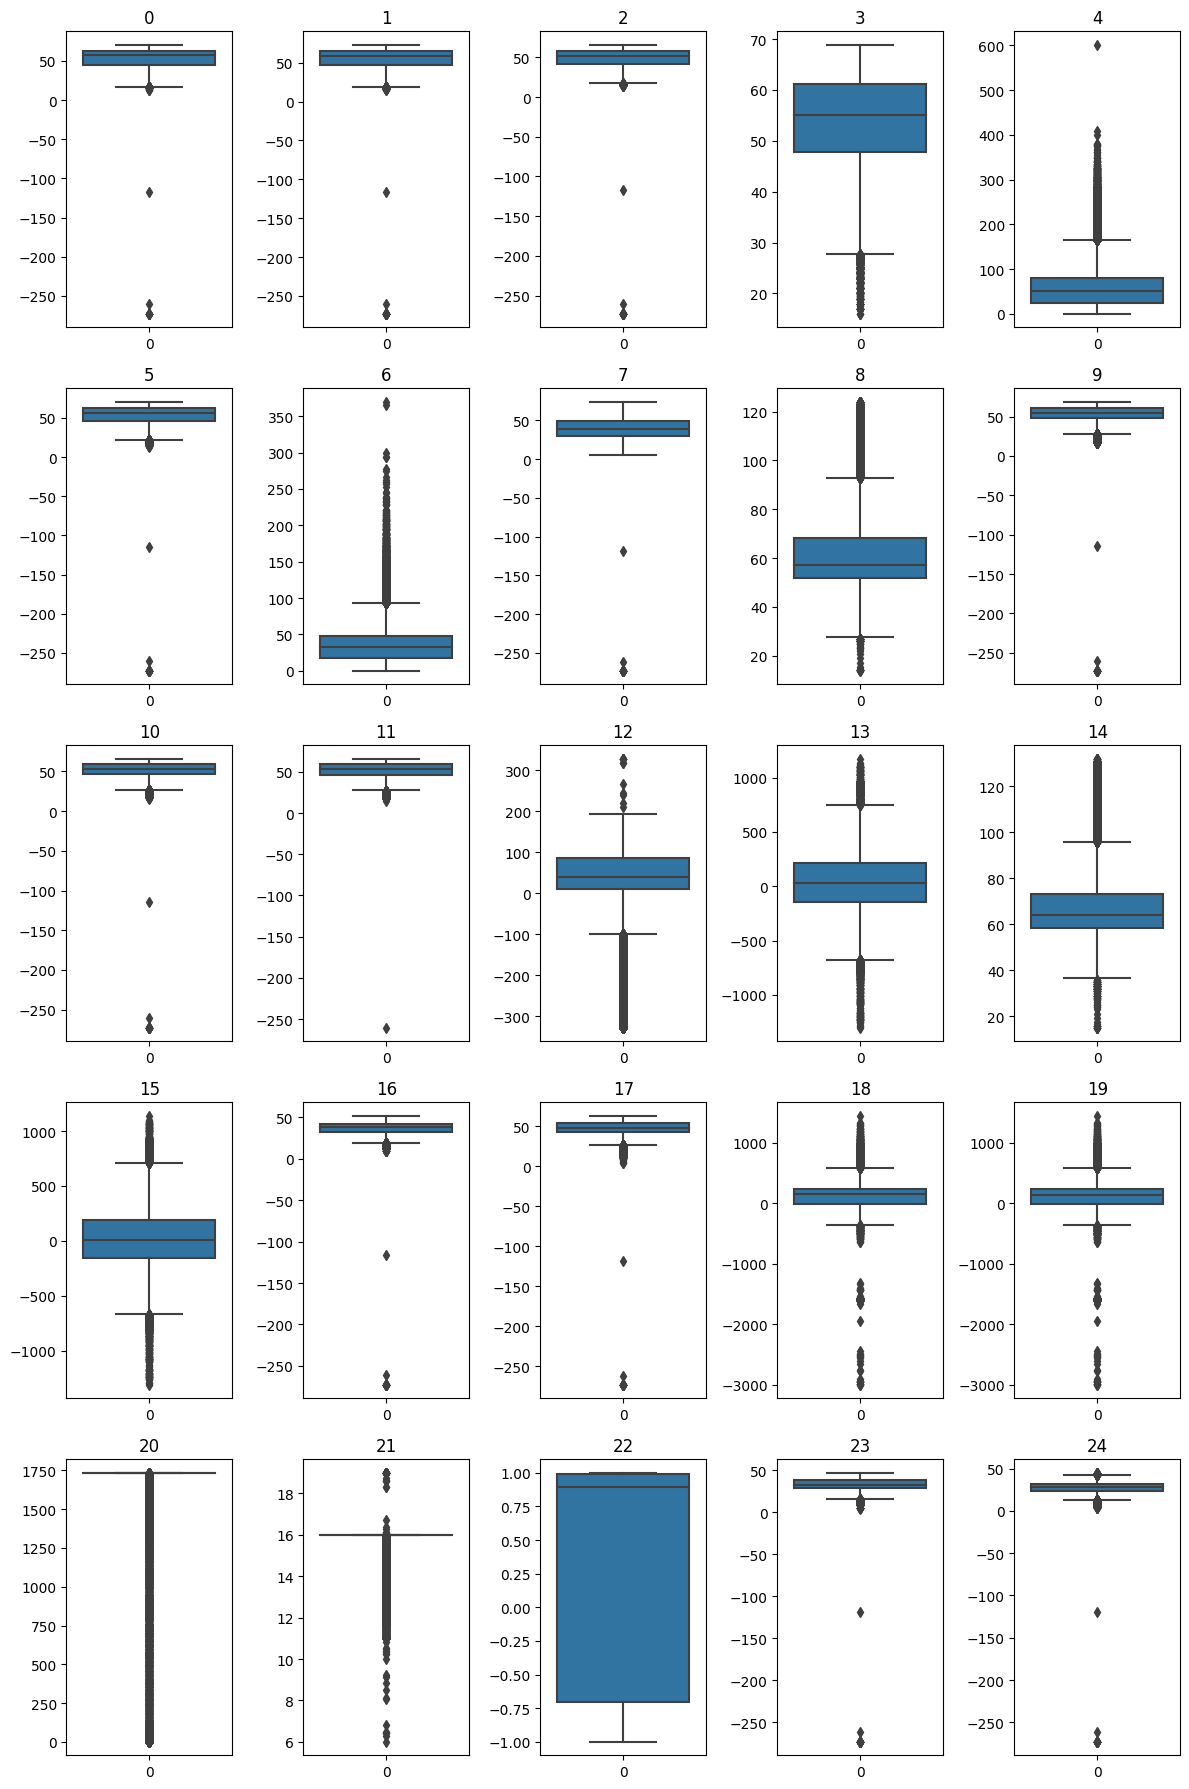

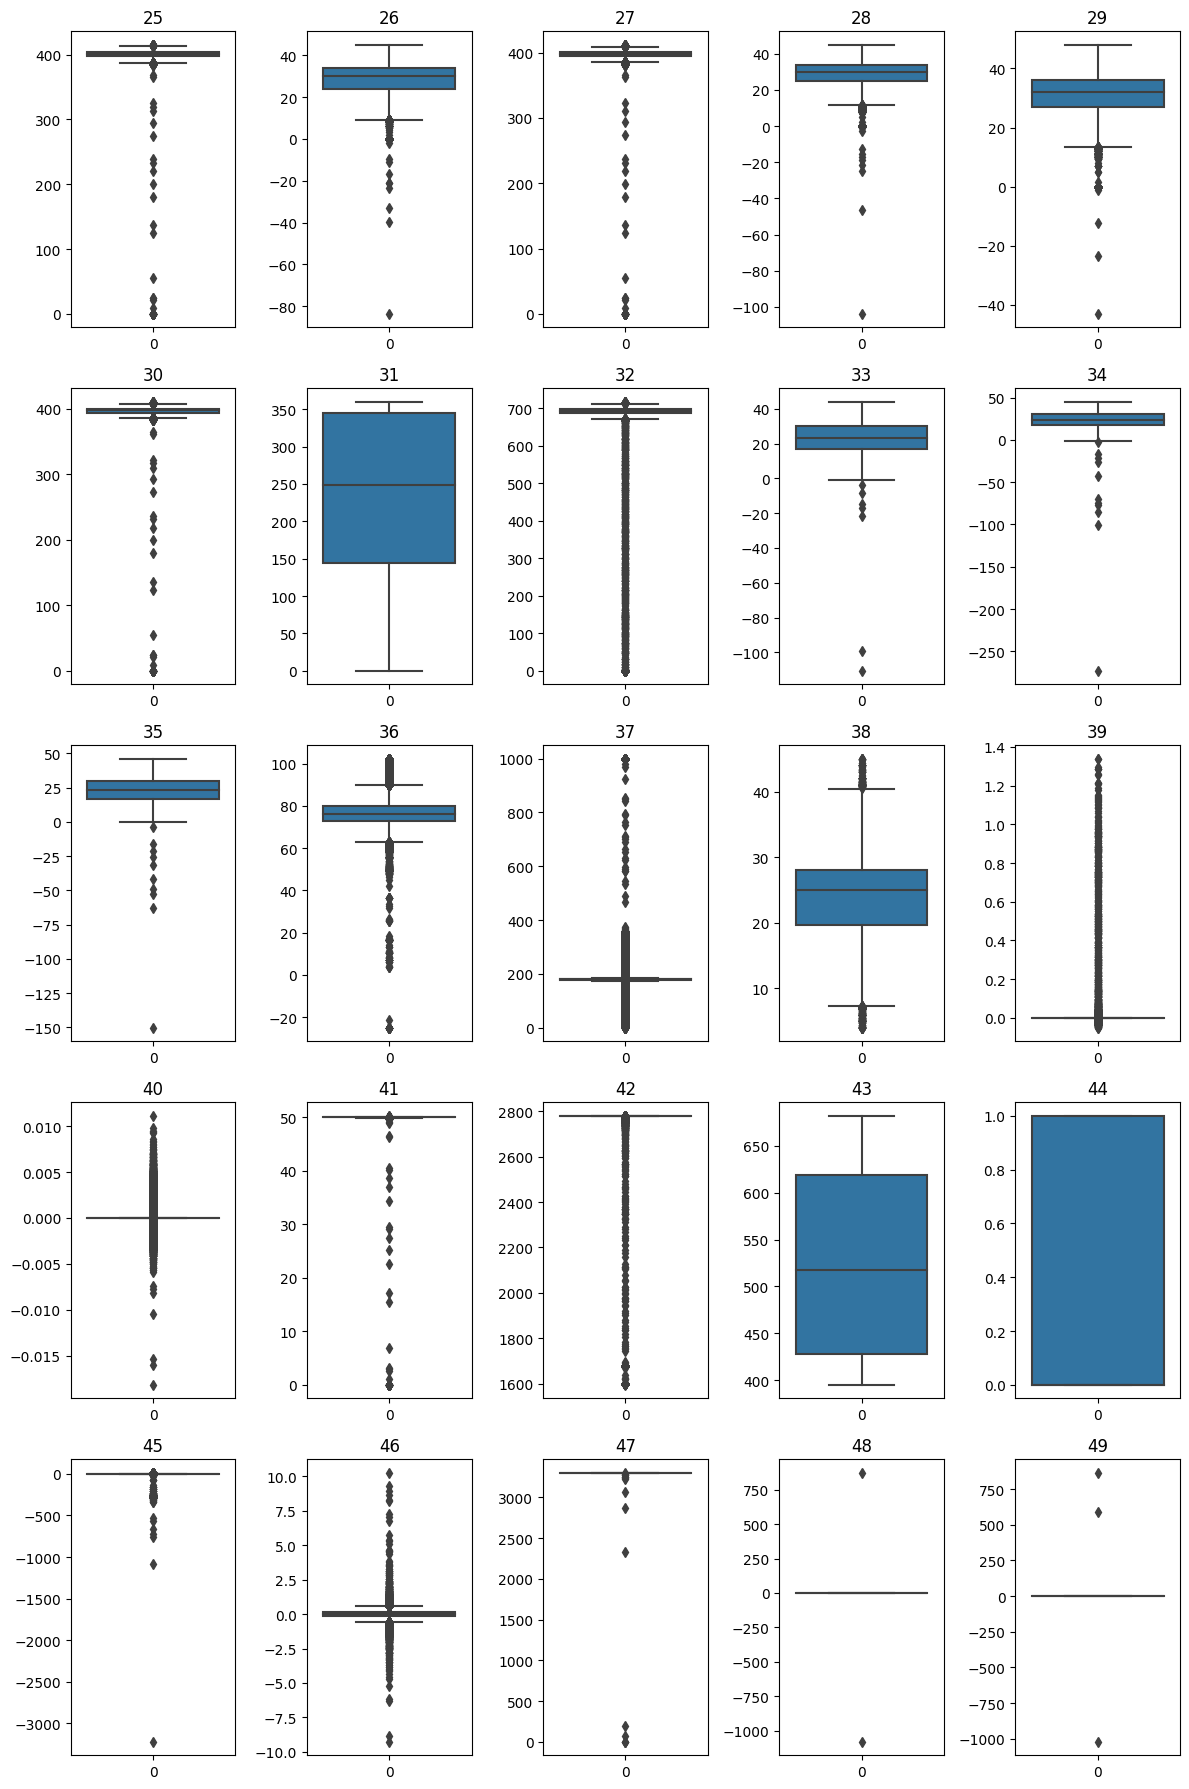

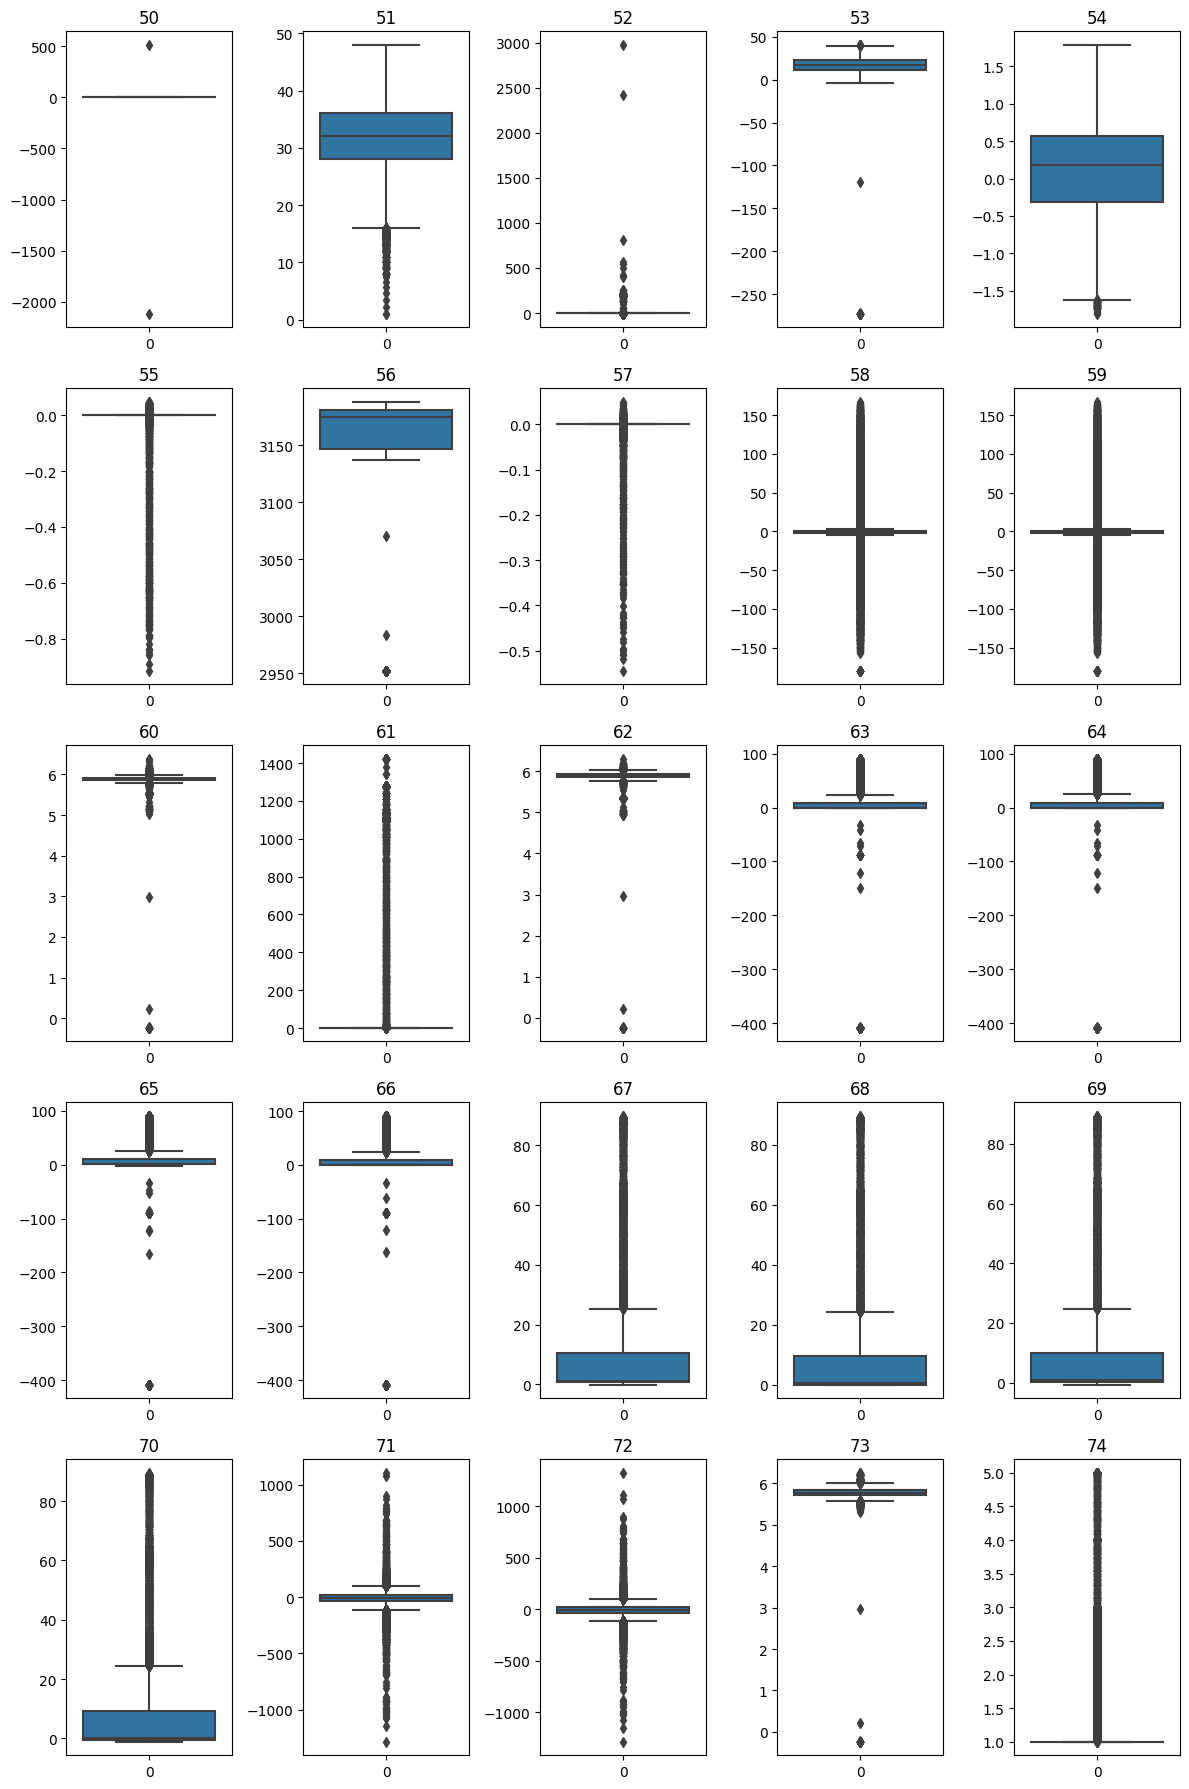

In [8]:
# boxplot for each feature
fig_fun(df_feature_lower,0,25)
plt.show()
fig_fun(df_feature_lower,25,50)
plt.show()
fig_fun(df_feature_lower,50,75)


In [ ]:
# combining the dataframes

df_combined=pd.concat([df_feature.loc[df_feature.index<=df_power.index[-1]].copy(),df_power],axis=1)

In [1]:
# def fig_fun(ind_strt,ind_end):
#     fig,axs=plt.subplots(5,5,figsize=(12,18))
#     axs=axs.reshape(-1)
#     c=0
#     for i in range(ind_strt,ind_end):
#         sns.histplot(df_feature.iloc[:,i][df_feature.iloc[:,i]<25000],bins=10,ax=axs[c])
#         c+=1

#     plt.tight_layout()
    
    
    
# fig_fun(0,25)
# plt.show()
# fig_fun(25,50)
# plt.show()
# fig_fun(50,75)

<Axes: xlabel='Timestamp'>

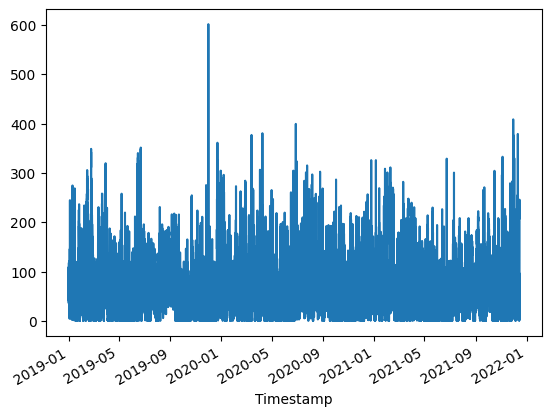

In [74]:
df_feature.iloc[:,4][df_feature.iloc[:,4].values<70000].plot()

<Axes: xlabel='Timestamp'>

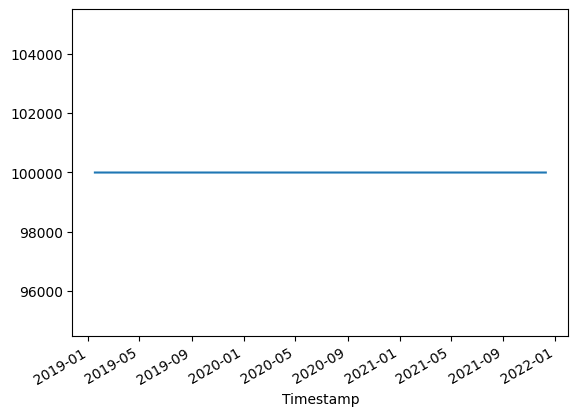

In [78]:
df_feature.iloc[:,4][df_feature.iloc[:,4].values>89000].plot()

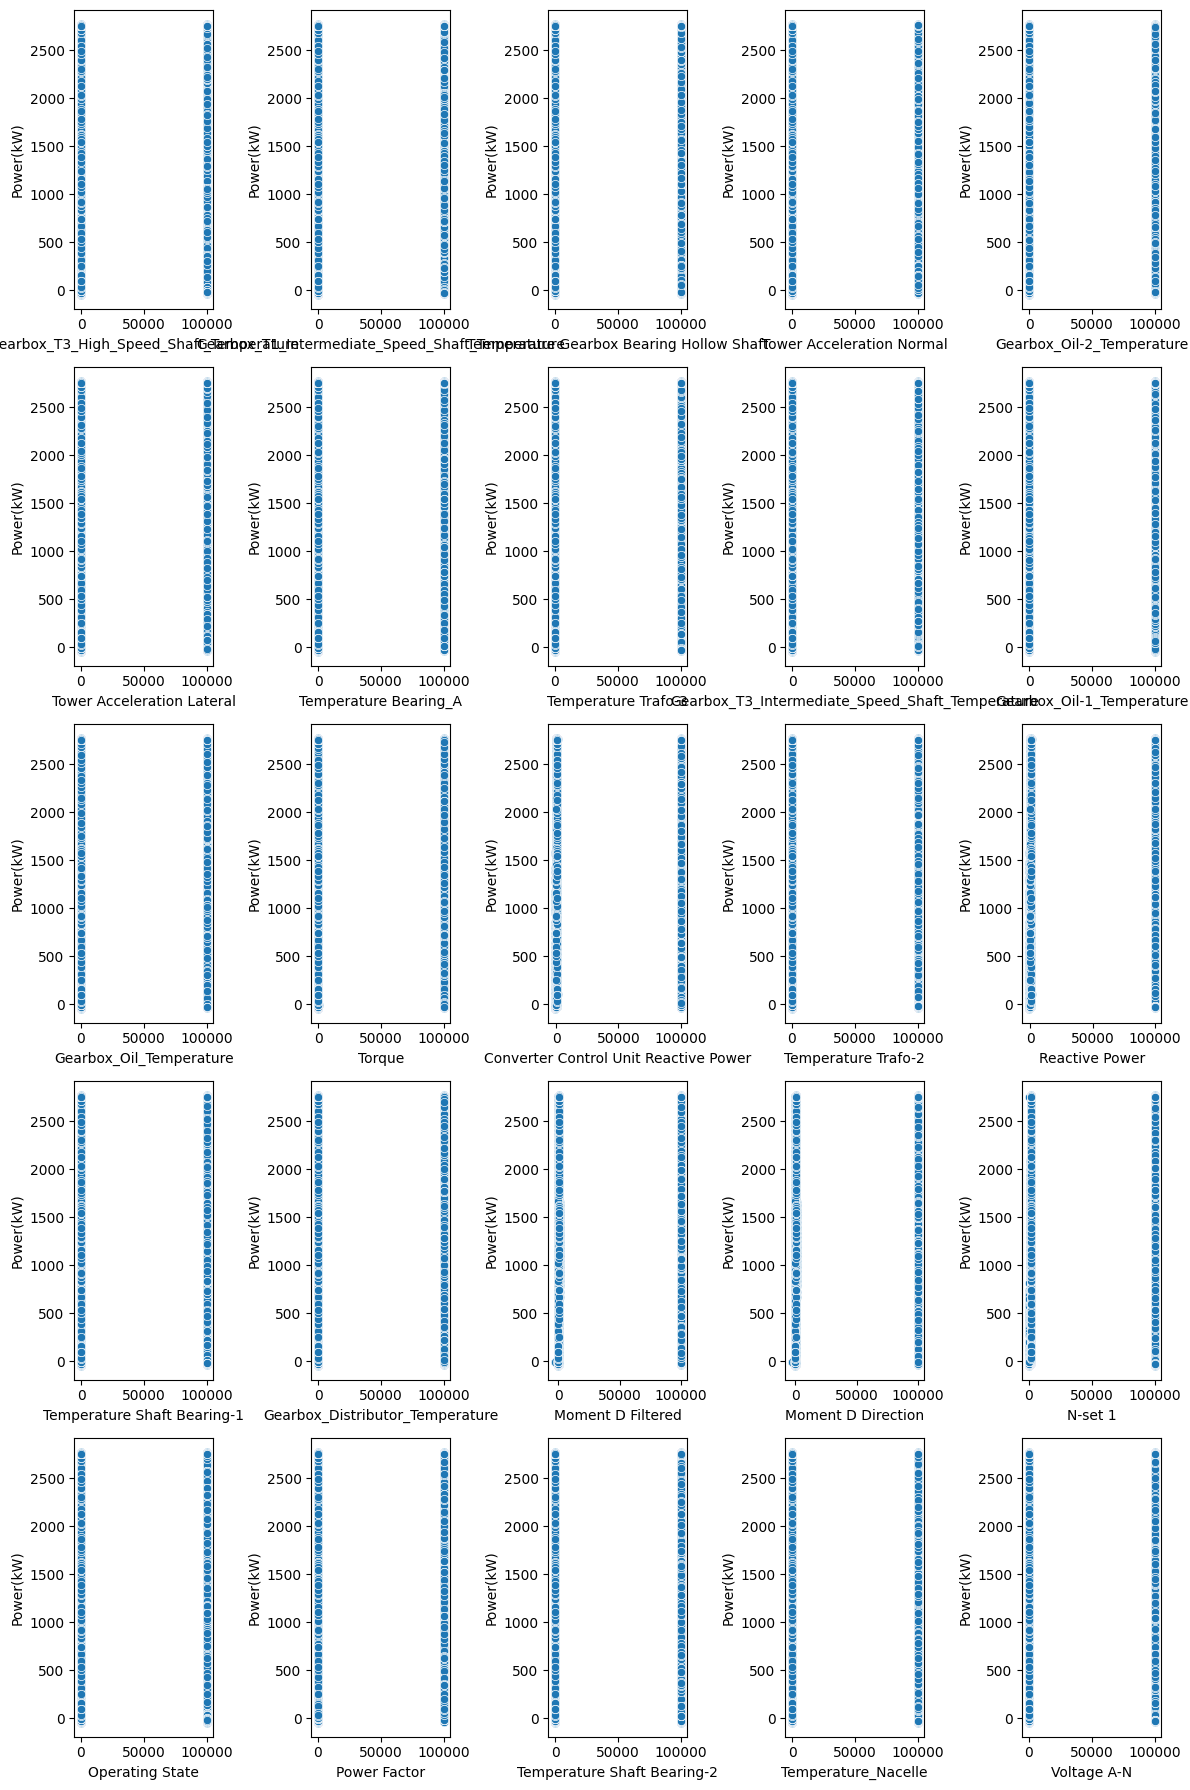

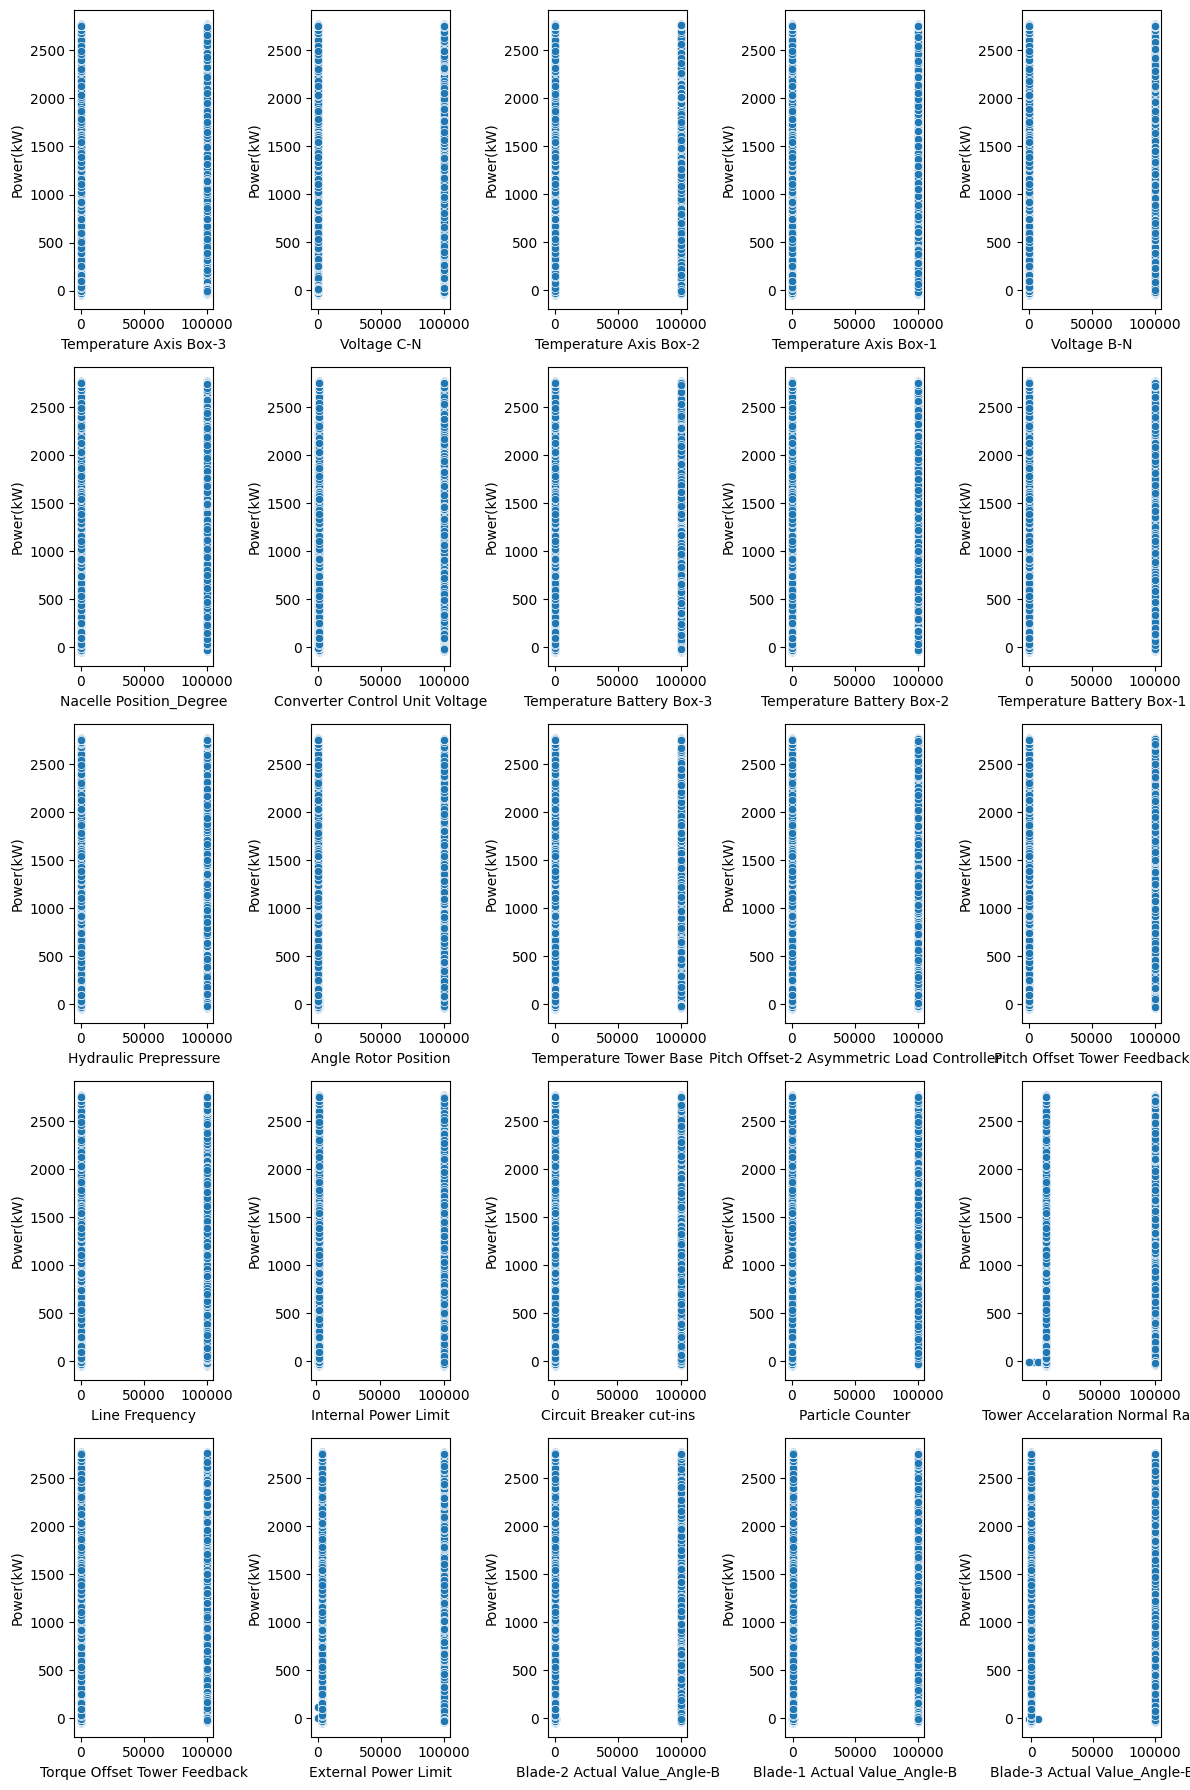

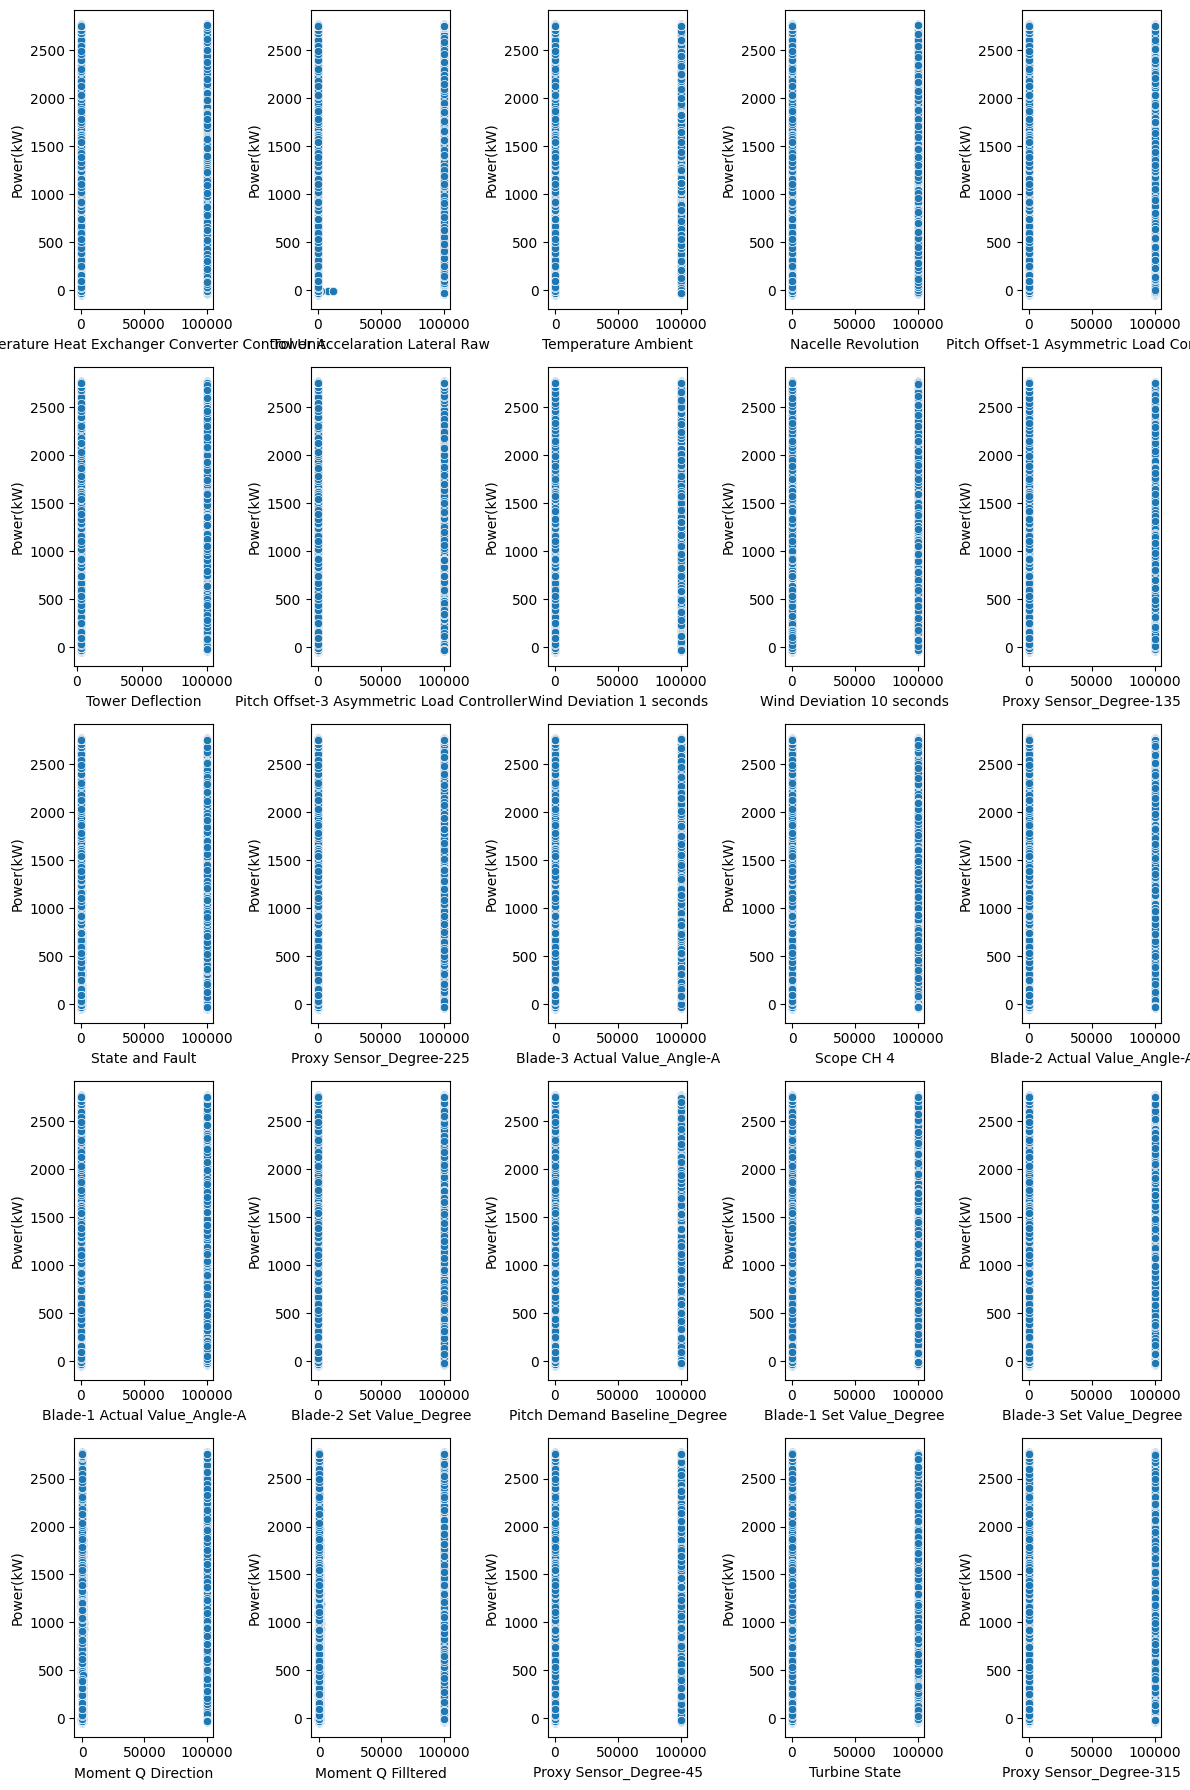

In [57]:

def fig_fun(ind_strt,ind_end):
    fig,axs=plt.subplots(5,5,figsize=(12,18))
    axs=axs.reshape(-1)

    for i, col in enumerate(df_combined.columns[ind_strt:ind_end]):
        sns.scatterplot(data=df_combined, x=col, y="Power(kW)", ax=axs[i])

    plt.tight_layout()

    
fig_fun(1,26)
plt.show()
fig_fun(26,51)
plt.show()
fig_fun(51,76)


In [ ]:
# plt.show()
# fig,axs=plt.subplots(5,5,figsize=(12,18))
# axs=axs.reshape(-1)

# for i, col in enumerate(df_combined.columns[26:51]):
#     sns.scatterplot(data=df_combined, x=col, y="Power(kW)", ax=axs[i])
    
# plt.tight_layout()

# plt.show()
# fig,axs=plt.subplots(5,5,figsize=(12,18))
# axs=axs.reshape(-1)

# for i, col in enumerate(df_combined.columns[51:76]):
#     sns.scatterplot(data=df_combined, x=col, y="Power(kW)", ax=axs[i])
    
# plt.tight_layout()

# Split the data into train and test

In [7]:
# training data 
train_feature=df_feature.loc[df_feature.index<=df_power.index[-1]].copy()
train_power=df_power.copy()

# test data
test_feature=df_feature.loc[df_feature.index>df_power.index[-1]].copy()

# load the submission data which only have the timestamp, and fill the power column with our prediction
df_test_power=pd.read_csv('/kaggle/input/wind-turbine-energy-kw-generation-data/sample_submission.csv')
df_test_power['Timestamp']=pd.to_datetime(df_test_power['Timestamp'])
df_test_power.set_index('Timestamp',inplace=True)
df_test_power

,Power(kW)
Timestamp,
2021-08-15 00:00:00,0
2021-08-15 00:10:00,0
2021-08-15 00:20:00,0
2021-08-15 00:30:00,0
2021-08-15 00:40:00,0
...,...
2021-12-14 23:10:00,0
2021-12-14 23:20:00,0
2021-12-14 23:30:00,0
